In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data
df = pd.read_csv("traffic_data.csv", parse_dates=["Datetime"])

#Statistics of the data
print(df.shape)

print(df.info())

print(df["Visits"].describe())

print(df.groupby("Store")["Visits"].mean())

print(df.groupby("Weather")["Visits"].median())



(78843, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78843 entries, 0 to 78842
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  78843 non-null  datetime64[ns]
 1   Store     78843 non-null  object        
 2   Visits    78843 non-null  int64         
 3   Weather   78843 non-null  object        
 4   Event     11761 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.0+ MB
None
count    78843.000000
mean       162.437363
std         93.402767
min         12.000000
25%         92.000000
50%        129.000000
75%        224.000000
max        595.000000
Name: Visits, dtype: float64
Store
Store_A    117.808188
Store_B    204.817929
Store_C    164.685971
Name: Visits, dtype: float64
Weather
Cloudy    122.0
Rainy     102.0
Sunny     135.0
Name: Visits, dtype: float64


In [11]:
# Comments:
# The dataset consists of 5 columns: Datetime, Store (Store A, B, and C), Visits per store, Weather (Sunny, Cloudy, Rainy), 
#and Event (Holiday or Promotion).
# On average, Store A receives approximately 118 visits, Store B about 205 visits, and Store C around 165 visits.
# Visits are also influenced by the weather: sunny days see higher traffic, with an average of 135 visits.

In [2]:
#Total visits per day and statistics per store

daily_visits = df.resample("D", on="Datetime").sum(numeric_only=True)
stats_store = df.groupby("Store")["Visits"].agg(["mean", "max", "min", "std"])
print(stats_store)

#Average visits per hour
hourly_stats = df.groupby(df["Datetime"].dt.hour)["Visits"].mean()
print(hourly_stats)

               mean  max  min         std
Store                                    
Store_A  117.808188  352   12   61.879047
Store_B  204.817929  595   37  105.792424
Store_C  164.685971  486   34   85.783242
Datetime
0     103.744221
1     104.270624
2     104.370167
3     103.773212
4     104.248097
5     103.919635
6     103.650533
7     103.997869
8     103.901979
9     104.150076
10    259.382040
11    260.604871
12    259.276104
13    260.292237
14    259.609132
15    260.817047
16    258.827397
17    259.894977
18    260.287367
19    103.647793
20    103.708676
21    103.913242
22    103.874581
23    104.388432
Name: Visits, dtype: float64


In [12]:
# Comments:
# We can observe that visits start increasing from 10 AM and continue to grow steadily until 6 PM.


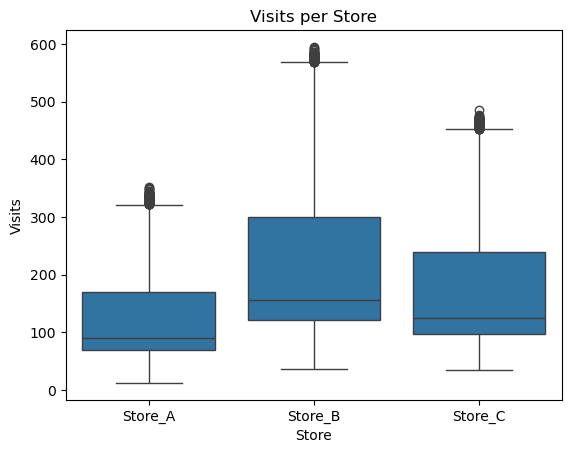

In [14]:
#Boxplot of visits
sns.boxplot(x="Store", y="Visits", data=df)
plt.title("Visits per Store")
plt.show()


In [ ]:
# Comments:
# The boxplot shows that Store B generally has the highest number of visits, while Store A has the lowest. 
#The spread of visits is also larger for Store C, indicating more variability. A few outliers are visible, representing unusually high or low traffic.

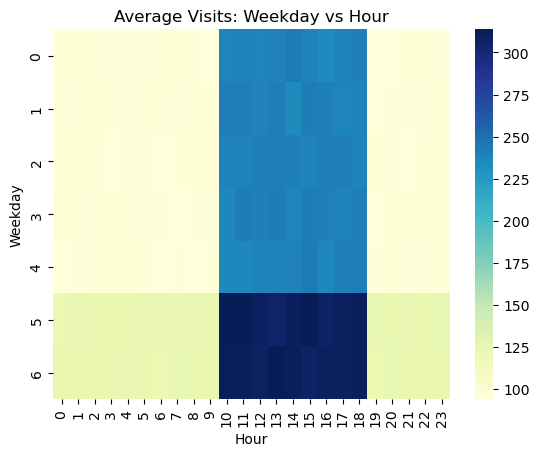

In [15]:
#Heatmap for the distribution of visits per weekday and hour
hourly = df.groupby([df["Datetime"].dt.weekday, df["Datetime"].dt.hour])["Visits"].mean().unstack()
sns.heatmap(hourly, cmap="YlGnBu")
plt.title("Average Visits: Weekday vs Hour")
plt.xlabel("Hour")
plt.ylabel("Weekday")
plt.show()

In [ ]:
# Comments:
# The heatmap confirms that visits are highest between 10 AM and 6 PM, 
# and that traffic is generally greater on Saturdays and Sundays.

C:\Users\wvg9824\AppData\Local\Temp\ipykernel_24804\1540766218.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_visits = df.resample("M", on="Datetime")["Visits"].sum()


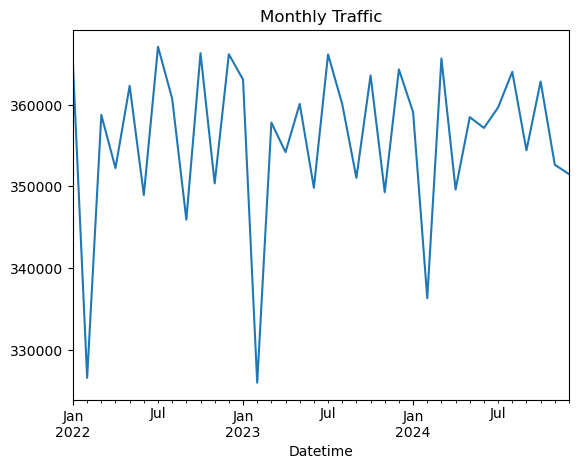

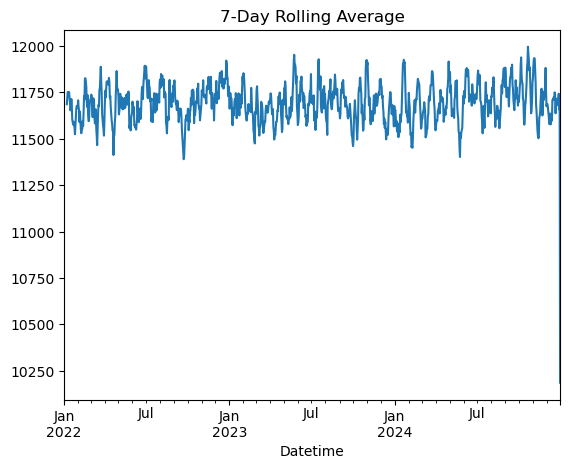

In [4]:
#Aggregation per month
monthly_visits = df.resample("M", on="Datetime")["Visits"].sum()
monthly_visits.plot(title="Monthly Traffic")
plt.show()

#Moving average
daily_visits["Visits"].rolling(7).mean().plot(title="7-Day Rolling Average")
plt.show()


In [ ]:
# Comments:
# The data shows clear seasonality, with lower traffic observed in February each year.
# The 7-day rolling average smooths daily fluctuations, making it easier to observe the overall traffic trend over time.


                  Visits  Weather_numeric
Visits           1.00000         -0.13947
Weather_numeric -0.13947          1.00000


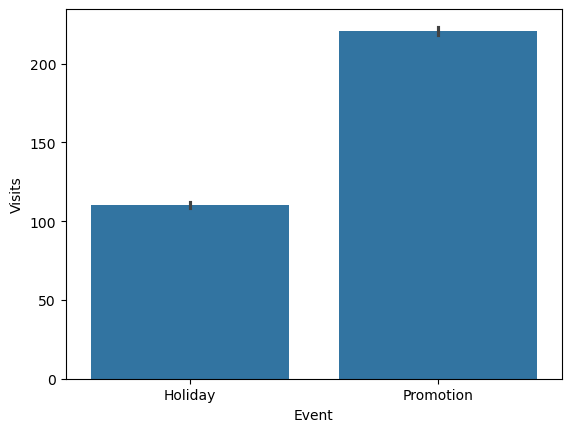

In [5]:
#Correlation between visits and weather
df["Weather_numeric"] = df["Weather"].map({"Sunny":1, "Cloudy":2, "Rainy":3})
corr = df[["Visits", "Weather_numeric"]].corr()
print(corr)

#Visits by events
sns.barplot(x="Event", y="Visits", data=df)
plt.show()


In [ ]:
# Comments:
# The correlation matrix shows that 'Visits' and 'Weather_numeric' have a weak negative correlation of -0.14.
# This indicates that weather has a slight impact on traffic: as the weather value increases 
# (e.g., from Sunny=1 to Rainy=3), the number of visits tends to decrease slightly.
# Overall, the relationship is weak, suggesting that other factors likely have a stronger influence on visits.

# Comments:
# The barplot shows that events have a clear impact on visits.
# On average, holidays see just over 100 visits, while promotions drive higher traffic, averaging more than 200 visits.


    Datetime  Visits
0 2022-01-01    3305
1 2022-01-02    3333
2 2022-01-03    2410
3 2022-01-04    2501
4 2022-01-05    2802


15:23:57 - cmdstanpy - INFO - Chain [1] start processing
15:23:58 - cmdstanpy - INFO - Chain [1] done processing


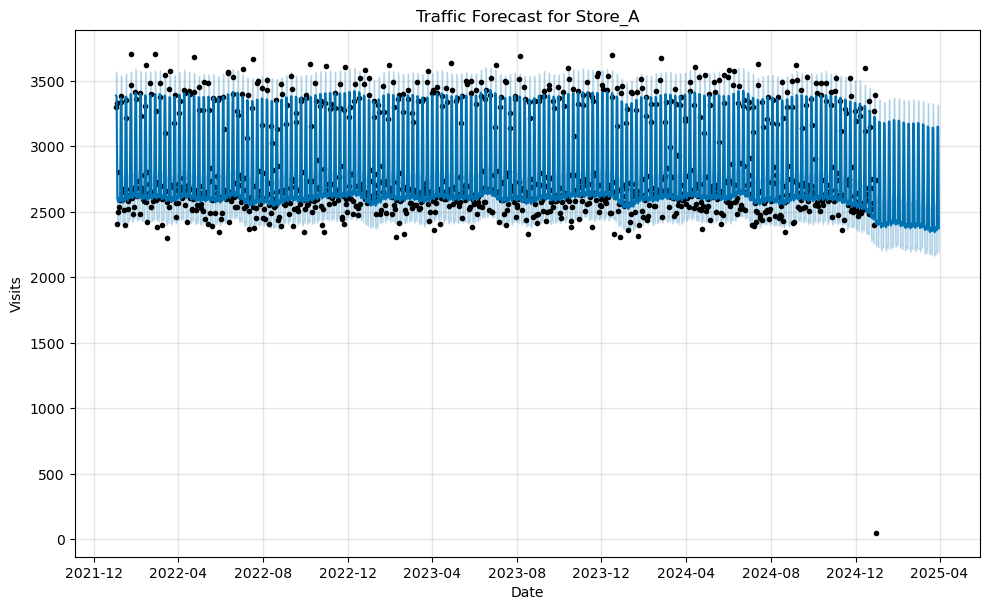

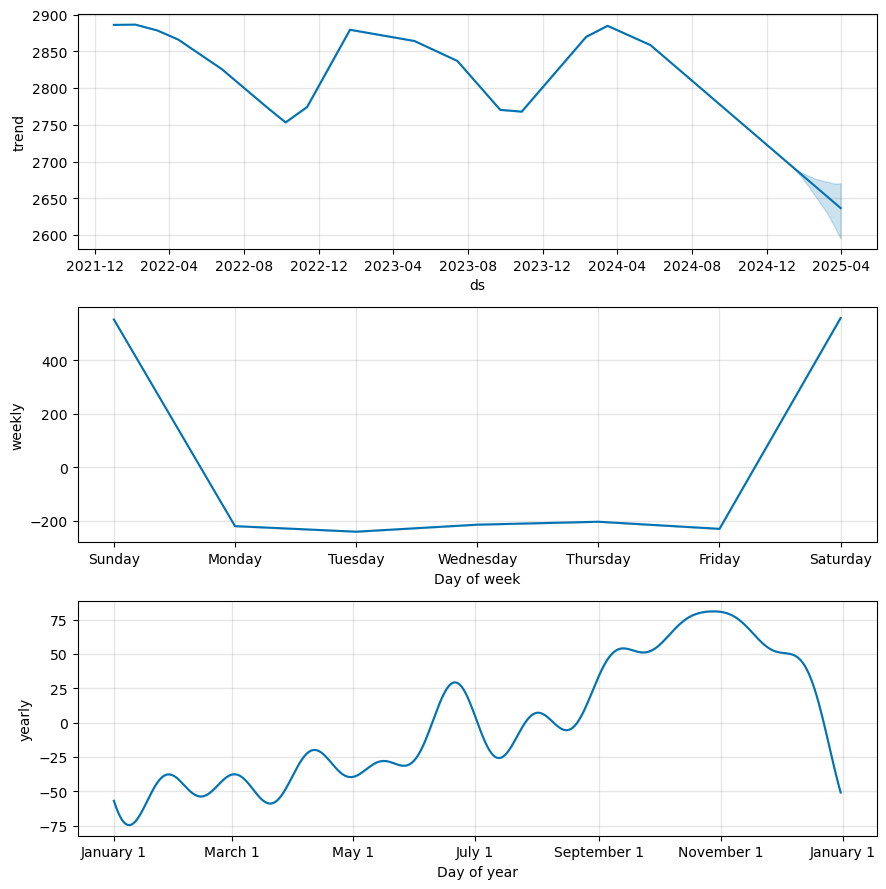

In [18]:
#Forecasting for the Store A
store = "Store_A"
data = df[df["Store"] == store].copy()

daily_data = data.resample("D", on="Datetime").sum(numeric_only=True).reset_index()
daily_data = daily_data[["Datetime", "Visits"]]


print(daily_data.head())
daily_data = daily_data.rename(columns={"Datetime": "ds", "Visits": "y"})

#Forecast using Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5
)

model.fit(daily_data)

future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title(f"Traffic Forecast for {store}")
plt.xlabel("Date")
plt.ylabel("Visits")
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


In [19]:
# Afficher le forecast quotidien pour Store A
forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(forecast_table.tail(30))  # dernières 30 lignes pour voir le futur

# Optionnel : agrégation mensuelle pour un tableau synthétique
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_forecast = forecast.groupby('month')['yhat'].sum().reset_index()
monthly_forecast = monthly_forecast.rename(columns={'yhat': 'Predicted_Visits'})
print(monthly_forecast)


             ds         yhat   yhat_lower   yhat_upper
1156 2025-03-02  3173.531921  3001.871756  3343.256734
1157 2025-03-03  2398.310329  2216.373214  2575.737740
1158 2025-03-04  2376.449008  2199.812532  2548.839812
1159 2025-03-05  2401.398107  2231.899564  2567.657478
1160 2025-03-06  2410.713966  2232.196353  2588.696782
1161 2025-03-07  2382.241276  2227.454807  2559.072399
1162 2025-03-08  3170.367247  2989.320413  3345.267707
1163 2025-03-09  3162.404220  2984.982955  3339.447584
1164 2025-03-10  2385.489239  2216.881268  2575.965003
1165 2025-03-11  2362.141870  2179.695620  2528.454968
1166 2025-03-12  2385.862046  2194.374294  2563.027235
1167 2025-03-13  2394.248816  2226.137986  2570.542993
1168 2025-03-14  2365.181213  2187.876296  2547.798455
1169 2025-03-15  3153.071384  2985.073374  3330.804752
1170 2025-03-16  3145.246426  2973.338182  3330.542010
1171 2025-03-17  2368.847487  2190.291417  2539.429506
1172 2025-03-18  2346.387410  2176.622941  2514.788480
1173 2025-